# Prerequisite

In [0]:
%pip install requests

Python interpreter will be restarted.
Python interpreter will be restarted.


Installing stats model to do time series analysis

In [0]:
%pip install statsmodels

Python interpreter will be restarted.
Python interpreter will be restarted.


# Step 1: Data Preparation

## Step 1.1: Download the data in local tmp

In [0]:
import requests

# Can use this public CSV path
# Note the url will only be valid for a certain period of time (max 12 hours)

# Pre-signed URL
csv_url = "https://storage.googleapis.com/project-clickstream-team-81/4f-lv-final-export.csv"

# Temporary local path
local_path = "/tmp/4f-lv-final-export.csv"

# Download the file in chunks to the local /tmp directory
with requests.get(csv_url, stream=True) as r:
    r.raise_for_status()  # Ensure there are no connection issues
    with open(local_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):  # 8KB chunks
            if chunk:
                f.write(chunk)

# Use dbutils to copy the file from /tmp to DBFS
dbutils.fs.cp(f"file://{local_path}", "/dbfs/tmp/4f-lv-final-export.csv")

# Now load the file using Spark, with repartitioning
# Note that we also need to separate columns with the delimiter ";"
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("sep", ";") \
    .option("inferSchema", "true") \
    .load("/dbfs/tmp/4f-lv-final-export.csv") \
    .repartition(10)

# Show the first 5 rows of the PySpark Dataframe
df.show(5, truncate=False)

# Print the schema to check the column names
df.printSchema()

+--------+----------------+----------------------------------------------------------------+------+------------------------------------+-------------------------------------------------------------------------------------------------+-------+-------------------------------+--------+------+----+-------------------+-----------------------------------------------------------------------+-----------+
|token   |fingerprint     |userToken                                                       |siteId|userId                              |url                                                                                              |type   |group                          |category|action|name|time               |visitKey                                                               |groupSource|
+--------+----------------+----------------------------------------------------------------+------+------------------------------------+----------------------------------------------------------------

## Step 1.2: Read from local temp and load first 500K rows into dataframe for quicker experiment

In [0]:
import pandas as pd
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.getOrCreate()

# Read the first 1000 lines from the CSV using Pandas
local_path = "/tmp/4f-lv-final-export.csv"
# Try using ISO-8859-1 encoding
try:
    df_pd = pd.read_csv(local_path, delimiter=';', nrows=500000, encoding='ISO-8859-1')
except UnicodeDecodeError as e:
    print("Encoding error:", e)

# Convert the Pandas DataFrame to a Spark DataFrame
df_spark = spark.createDataFrame(df_pd)

# Show schema and sample data
df_spark.printSchema()
df_spark.show(5)

root
 |-- token: long (nullable = true)
 |-- fingerprint: string (nullable = true)
 |-- userToken: string (nullable = true)
 |-- siteId: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- url: string (nullable = true)
 |-- type: string (nullable = true)
 |-- group: string (nullable = true)
 |-- category: string (nullable = true)
 |-- action: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- visitKey: string (nullable = true)
 |-- groupSource: string (nullable = true)

+--------+----------------+--------------------+------+--------------------+--------------------+-------+--------------------+-----------+----------+----+-------------------+--------------------+-----------+
|   token|     fingerprint|           userToken|siteId|              userId|                 url|   type|               group|   category|    action|name|               time|            visitKey|groupSource|
+--------+----------------+-----------------

## Step 1.3: extracted page name (i.e *.html) from url

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, regexp_replace, expr, split, when

# Filter out null userId and url, and create new columns for cleaning URLs
df_pages = df_spark.filter(
    ~isnull(col("userId")) &
    ~isnull(col("url")) 
).select(
    col("*"),  # Select all existing columns
    # Remove query parameters from the URL
    regexp_replace(col("url"), r'\?.*$', '')  # Removes everything after '?'
    .alias("cleaned_url"),  # Renamed cleaned URL
    # Extract the main category or section from the cleaned URL
    expr("substring_index(substring_index(cleaned_url, '/', -1), '?', 1) as page"),  # Extracts the file name
)

# Show the filtered DataFrame
df_pages.select("url", "page").show(5, truncate=False)


+----------------------------------------------------------------------------+---------------------------------------------------------+
|url                                                                         |page                                                     |
+----------------------------------------------------------------------------+---------------------------------------------------------+
|https://4fstore.lv/zenu-gluds-polo-krekls-4fjs23tshm295-45s.html            |zenu-gluds-polo-krekls-4fjs23tshm295-45s.html            |
|https://4fstore.lv/viriesi/apgerbs/dzemperi/page-2.html                     |page-2.html                                              |
|https://4fstore.lv/sievietes/page-3.html                                    |page-3.html                                              |
|https://4fstore.lv/viriesu-velosorti-ar-gela-ieliktni-4fs23tfshm156-20s.html|viriesu-velosorti-ar-gela-ieliktni-4fs23tfshm156-20s.html|
|https://4fstore.lv/sievietes/apgerbs/pel

## Step 2: Visit count by week and page

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, weekofyear, year, count, to_date, date_add, expr

# Select only the necessary columns
df_visits = df_pages.select("time", "page")

# Ensure 'time' is in timestamp format
df_visits = df_visits.withColumn("time", col("time").cast("timestamp"))

# Extract year and week from the timestamp
df_visits = df_visits.withColumn("year", year(col("time"))) \
                     .withColumn("week", weekofyear(col("time")))

# Group by year, week, and page to count visits
df_weekly_visits_per_page = df_visits.groupBy("year", "week", "page").agg(
    count("*").alias("visit_count")  # Count of visits
)

# Create a date column representing the first day of the week
df_weekly_visits_per_page = df_weekly_visits_per_page.withColumn("week_start_date", expr("date_add(to_date(concat(year, '-01-01')), (week - 1) * 7)"))

# Drop unnecessary columns
df_weekly_visits_per_page_time_series = df_weekly_visits_per_page.select("week_start_date", "page", "visit_count")

# Show the resulting time series DataFrame
df_weekly_visits_per_page_time_series.show(truncate=False)


+---------------+----------------------------------------------------------------------------+-----------+
|week_start_date|page                                                                        |visit_count|
+---------------+----------------------------------------------------------------------------+-----------+
|2023-10-22     |meitenu-dunu-bezrocis-ar-sintetisku-pildijumu-4fjaw23tvjaf045-34s.html      |2          |
|2023-06-25     |sieviesu-pilsetas-virsjaka-parka-membrana-5-0-4fs23tjaf234-20s.html         |15         |
|2023-04-23     |joger-tipa-meitenu-sporta-bikses-4fjaw2trof241-20s.html                     |1          |
|2023-10-08     |joger-tipa-meitenu-sporta-bikses-hjz2-jspd02-27m.html                       |3          |
|2023-10-22     |meitenes.html                                                               |53         |
|2023-11-19     |viriesu-sleposanas-bikses-membrana-dermizax-20-melnas-4faw23tftrm34-21s.html|1          |
|2023-09-17     |vinai.html          

## Step 3: Convert time series data into Trend, Seasonal and Residual using stats model
Time series seasonal-trend analysis breaks down a time series dataset (e.g., weekly visits) into different components to better understand patterns and make forecasts. The goal is to identify underlying trends, recurring seasonal effects, and random noise that may affect the data. This is often done using decomposition models like the Additive or Multiplicative models.

### Step 3.1: Trend, Seasonal and Residual for total visited count weekly for one page "aksesuari.html"

In [0]:
# Convert to page = aksesuari.html
df_weekly_visits_for_one_page_time_series = df_weekly_visits_per_page_time_series.filter(col("page") == "aksesuari.html").select("week_start_date", "visit_count")

# Convert to Pandas DataFrame
df_weekly_visits_for_one_page_pd = df_weekly_visits_for_one_page_time_series.toPandas()

# Set 'week_start_date' as the DataFrame index (required for time series)
weekly_visits_per_page_pd = df_weekly_visits_for_one_page_pd.set_index('week_start_date')

print(df_weekly_visits_for_one_page_pd.head(5))



  week_start_date  visit_count
0      2023-11-12          212
1      2023-11-05           51
2      2023-08-13           41
3      2023-10-22           92
4      2023-07-02           41


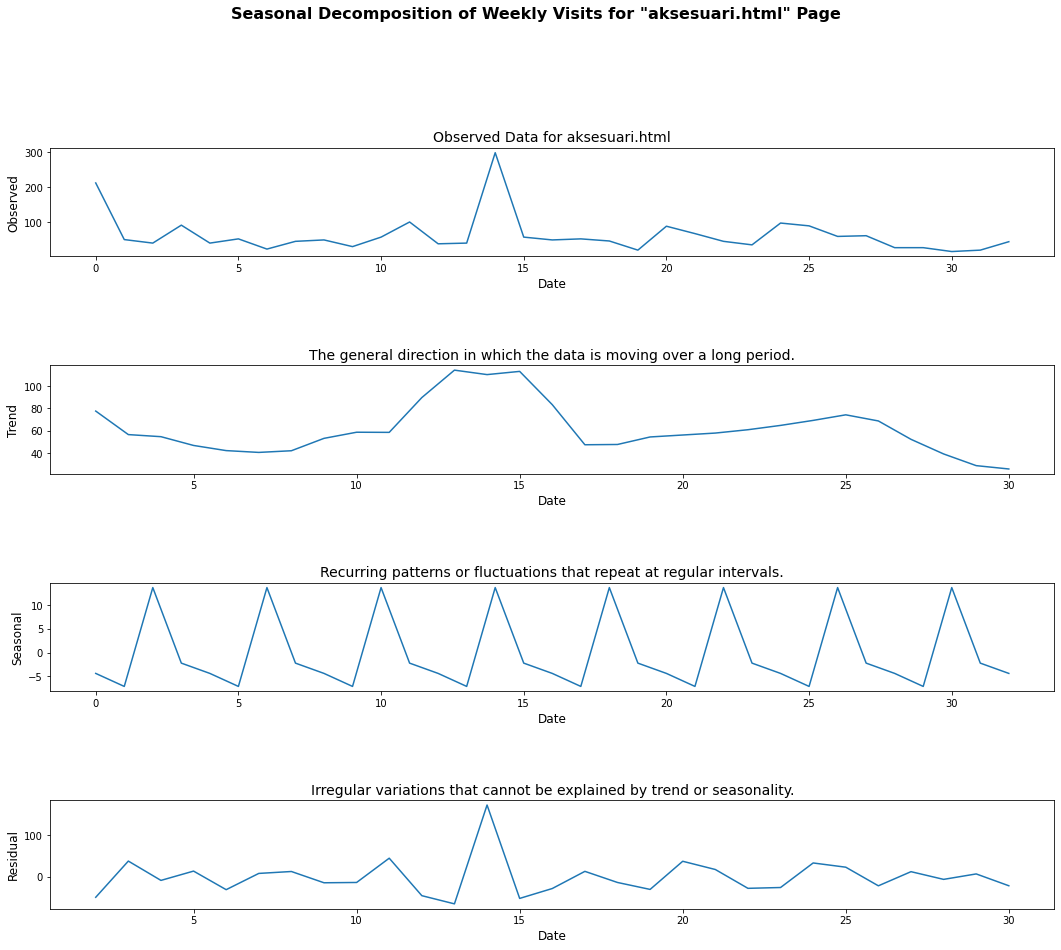

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
decomposition = seasonal_decompose(df_weekly_visits_for_one_page_pd['visit_count'], model='additive', period=4)

# Create subplots for each component
fig, axes = plt.subplots(4, 1, figsize=(18, 14), sharex=False)

# Plot each component
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel("Observed", fontsize=12)
axes[0].set_xlabel("Date", fontsize=12)  # Add x-label
axes[0].set_title("Observed Data for aksesuari.html", fontsize=14)

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel("Trend", fontsize=12)
axes[1].set_xlabel("Date", fontsize=12)  # Add x-label
axes[1].set_title("The general direction in which the data is moving over a long period.", fontsize=14)

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel("Seasonal", fontsize=12)
axes[2].set_xlabel("Date", fontsize=12)  # Add x-label
axes[2].set_title("Recurring patterns or fluctuations that repeat at regular intervals.", fontsize=14)

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel("Residual", fontsize=12)
axes[3].set_xlabel("Date", fontsize=12)  # Add x-label
axes[3].set_title("Irregular variations that cannot be explained by trend or seasonality.", fontsize=14)


# Adjust layout to give space between the graphs
fig.subplots_adjust(hspace = 1)  # Increase vertical space between plots

# Add an overall title
fig.suptitle("Seasonal Decomposition of Weekly Visits for \"aksesuari.html\" Page", fontsize=16, y=1.02, weight='bold')

# Show the plot
plt.show()


### Step 3.2: Trend, Seasonal and Residual for total visited count weekly across all pages

In [0]:
# Convert to Pandas DataFrame
weekly_visits_per_page_pd = df_weekly_visits_per_page_time_series.toPandas()

# Set 'week_start_date' as the DataFrame index (required for time series)
weekly_visits_per_page_pd = weekly_visits_per_page_pd.set_index('week_start_date')

# Aggregate data if needed (e.g., sum visits across pages for each week)
weekly_visits_across_all_pages = weekly_visits_per_page_pd.groupby(weekly_visits_per_page_pd.index).sum()

print(weekly_visits_across_all_pages.head())

                 visit_count
week_start_date             
2023-04-16              5242
2023-04-23              8363
2023-04-30              7554
2023-05-07              9483
2023-05-14              9700


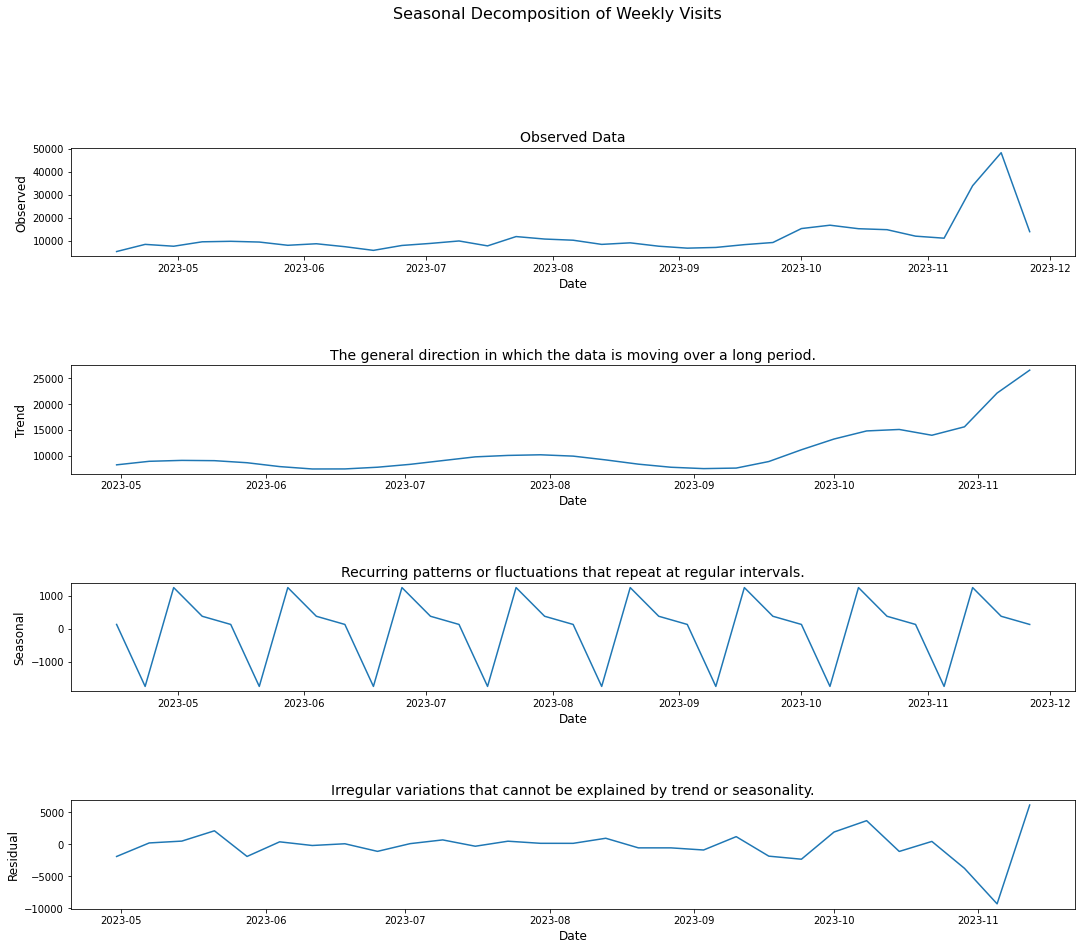

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_visits_across_all_pages['visit_count'], model='additive', period=4)

# Create subplots for each component
fig, axes = plt.subplots(4, 1, figsize=(18, 14), sharex=False)

# Plot each component
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel("Observed", fontsize=12)
axes[0].set_xlabel("Date", fontsize=12)  # Add x-label
axes[0].set_title("Observed Data", fontsize=14)

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel("Trend", fontsize=12)
axes[1].set_xlabel("Date", fontsize=12)  # Add x-label
axes[1].set_title("The general direction in which the data is moving over a long period.", fontsize=14)

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel("Seasonal", fontsize=12)
axes[2].set_xlabel("Date", fontsize=12)  # Add x-label
axes[2].set_title("Recurring patterns or fluctuations that repeat at regular intervals.", fontsize=14)

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel("Residual", fontsize=12)
axes[3].set_xlabel("Date", fontsize=12)  # Add x-label
axes[3].set_title("Irregular variations that cannot be explained by trend or seasonality.", fontsize=14)


# Adjust layout to give space between the graphs
fig.subplots_adjust(hspace = 1)  # Increase vertical space between plots

# Add an overall title
fig.suptitle("Seasonal Decomposition of Weekly Visits across all pages", fontsize=16, y=1.02, weight='bold')

# Show the plot
plt.show()


# end